# Pre-trained model transfer learning for application in the specific dataset scenario

## Importing libraries and loading the dataset

In [ ]:
import sys
import cv2
import time
import colorsys
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5-20220906T151844Z-001.zip

Archive:  /content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5-20220906T151844Z-001.zip
   creating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/assets/
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/saved_model.pb  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/variables/variables.index  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/keras_metadata.pb  
  inflating: 128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/variables/variables.data-00000-of-00001  


In [ ]:
!unzip /content/drive/MyDrive/Segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Segmentation_dataset/masked_silhouettes/001-nm-03-0004392.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-bg-03-0004394.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-bg-03-0004409.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-bg-03-0004410.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-02-0004445.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-02-0004446.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-02-0004453.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-05-0004483.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-05-0004489.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-05-0004491.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/001-cl-05-0004497.jpg  
  inflating: Segmentation_dataset/masked_silhouettes/002-nm-05-0004517.jpg  
  inflating: Segmentation

In [ ]:
!mkdir rgb
!mkdir masks

!mv /content/Segmentation_dataset/rgb_silhouettes /content/rgb 
!mv /content/Segmentation_dataset/masked_silhouettes /content/masks

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.1)       

In [ ]:
img_sil = "/content/rgb"
masked_sil = "/content/masks"

batch = 128

train_images_generator = data_generator.flow_from_directory(
                                        directory=img_sil,
                                        target_size=(128, 128),
                                        batch_size=batch,
                                        class_mode=None,
                                        classes=None,
                                        color_mode = 'rgb',
                                        subset='training',
                                        shuffle=True,
                                        seed=999,
                                        )

train_mask_generator = data_generator.flow_from_directory(
                                        directory=masked_sil,
                                        color_mode = 'grayscale',
                                        target_size=(128, 128),
                                        class_mode=None,
                                        classes=None,
                                        batch_size = batch,
                                        subset='training',
                                        shuffle=True,
                                        seed=999,
)

val_images_generator = data_generator.flow_from_directory(
                                        directory=img_sil,
                                        target_size=(128, 128),
                                        batch_size=batch,
                                        color_mode = 'rgb',
                                        class_mode=None,
                                        classes=None,
                                        subset='validation',
                                        shuffle=True,
                                        seed=999,
                                        )

val_mask_generator = data_generator.flow_from_directory(
                                        directory=masked_sil,
                                        color_mode = 'grayscale',
                                        target_size=(128, 128),
                                        class_mode=None,
                                        classes=None,
                                        batch_size = batch,
                                        subset='validation',
                                        shuffle=True,
                                        seed=999,
)

train_generator = zip(train_images_generator, train_mask_generator)
val_generator = zip(val_images_generator, val_mask_generator)

Found 17298 images belonging to 1 classes.
Found 17298 images belonging to 1 classes.
Found 1922 images belonging to 1 classes.
Found 1922 images belonging to 1 classes.


(128, 128, 128, 3)


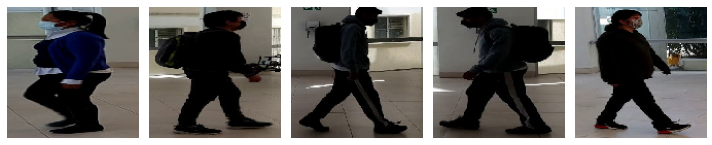

In [ ]:
images, masks = next(train_generator)

print(images.shape)
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
  ax.imshow(img)
  ax.axis("off")
plt.tight_layout()
plt.show()

(128, 128, 128, 1)


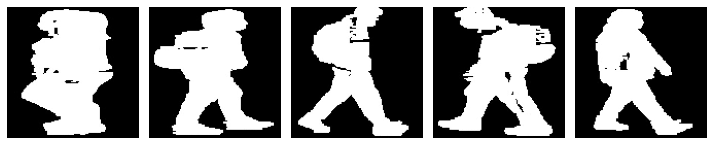

In [ ]:

fig, axes = plt.subplots(1, 5, figsize = (10, 10))
print(masks.shape)
axes = axes.flatten()
for msk, ax in zip(masks, axes):
  ax.imshow(np.squeeze(msk), cmap='gray')
  ax.axis("off")
plt.tight_layout()
plt.show()

## Loading the pre-trained model

In [ ]:
model_segmentation = tf.keras.models.load_model('/content/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5')

In [ ]:
model_segmentation.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_7 (Sequential)      (None, 64, 64, 16)   432         ['input_2[0][0]']                
                                                                                                  
 sequential_8 (Sequential)      (None, 32, 32, 32)   4672        ['sequential_7[0][0]']           
                                                                                                  
 sequential_9 (Sequential)      (None, 16, 16, 64)   18560       ['sequential_8[0][0]']     

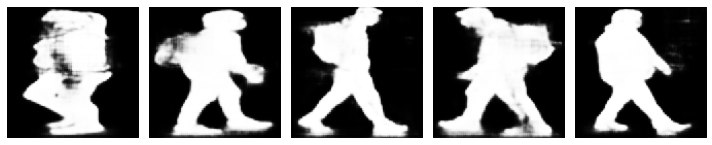

In [ ]:
result = model_segmentation(images)
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for res, ax in zip(result, axes):
  ax.imshow(np.squeeze(res),cmap="gray")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
images, masks = next(val_generator)

model_segmentation.evaluate(images,masks)

4/4 [==============================] - 1s 11ms/step - loss: 0.2278 - accuracy: 0.8528


[0.2278214693069458, 0.852776050567627]

## Feeding the model with the new data

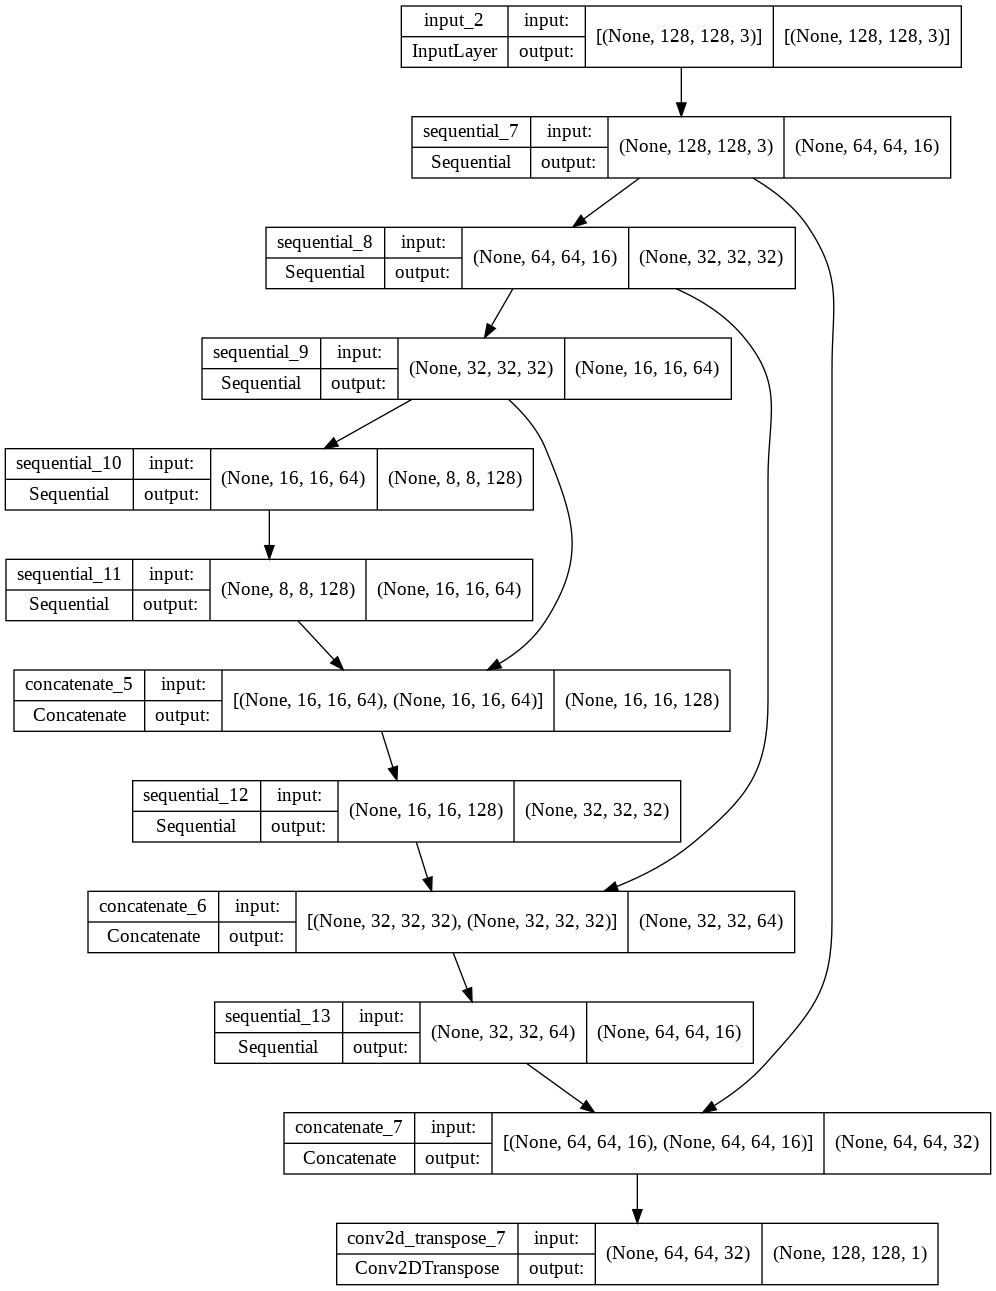

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    nesterov=True,
    name='SGD',
)

loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='binary_crossentropy'
)

#model_segmentation.compile(optimizer = optimizer, loss = loss, metrics = ["accuracy"])

tf.keras.utils.plot_model(model_segmentation, show_shapes=True, show_layer_names=True)

In [ ]:
training_samples = train_images_generator.n
validation_samples = val_images_generator.n

history_segmentation = model_segmentation.fit(
  train_generator,
  steps_per_epoch=training_samples // batch,
  epochs=50,
  validation_data=val_generator, 
  validation_steps=validation_samples // batch
)

Epoch 1/50
135/135 [==============================] - 50s 353ms/step - loss: 0.1657 - accuracy: 0.8639 - val_loss: 0.1165 - val_accuracy: 0.8780
Epoch 2/50
135/135 [==============================] - 47s 348ms/step - loss: 0.1461 - accuracy: 0.8686 - val_loss: 0.1117 - val_accuracy: 0.8795
Epoch 3/50
135/135 [==============================] - 46s 347ms/step - loss: 0.1402 - accuracy: 0.8700 - val_loss: 0.1074 - val_accuracy: 0.8808
Epoch 4/50
135/135 [==============================] - 46s 343ms/step - loss: 0.1360 - accuracy: 0.8711 - val_loss: 0.1036 - val_accuracy: 0.8821
Epoch 5/50
135/135 [==============================] - 47s 347ms/step - loss: 0.1331 - accuracy: 0.8718 - val_loss: 0.1011 - val_accuracy: 0.8826
Epoch 6/50
135/135 [==============================] - 46s 344ms/step - loss: 0.1305 - accuracy: 0.8724 - val_loss: 0.1003 - val_accuracy: 0.8829
Epoch 7/50
135/135 [==============================] - 46s 343ms/step - loss: 0.1286 - accuracy: 0.8729 - val_loss: 0.0985 - val_ac

In [ ]:
images, masks = next(val_generator)
model_segmentation.evaluate(images,masks)

4/4 [==============================] - 0s 12ms/step - loss: 0.0858 - accuracy: 0.8889


[0.08582932502031326, 0.8888950347900391]

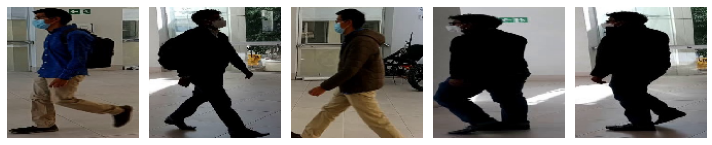

In [ ]:
images, masks = next(val_generator)
result = model_segmentation(images)
result = np.squeeze(result)

fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
  ax.imshow(img)
  ax.axis("off")
plt.tight_layout()
plt.show()

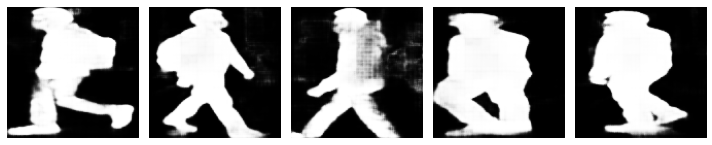

In [ ]:
fig, axes = plt.subplots(1, 5, figsize = (10, 10))
axes = axes.flatten()
for res, ax in zip(result, axes):
  ax.imshow(np.squeeze(res),cmap="gray")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
model_segmentation.save("128x128_acc_0.8786_loss_0.1018_val-acc_0.8875_val-loss_0.0817_0.22M_13-09-22-TF_OAKGait16")

In [ ]:
os.system("zip -r 128x128_acc_0.8786_loss_0.1018_val-acc_0.8875_val-loss_0.0817_0.22M_13-09-22-TF_OAKGait16.zip 128x128_acc_0.8786_loss_0.1018_val-acc_0.8875_val-loss_0.0817_0.22M_13-09-22-TF_OAKGait16")

0